# UAL Adapter Tutorial - Complete Guide

**Universal Architecture-Agnostic LoRA Transfer**

Learn to train LoRA adapters once and deploy across different model architectures.

## Contents:
1. Installation & Setup
2. Basic Cross-Architecture Transfer (GPT-2 to TinyLlama)
3. Multi-Domain Intelligent Dispatcher
4. Projection Methods Comparison
5. Production Medical Chatbot

**Time**: 20-30 minutes | **GPU**: Recommended | **Level**: Beginner-friendly

## Step 1: Installation

Install UAL Adapter and dependencies:

In [1]:
# Install packages
!pip install -q ual-adapter transformers torch accelerate
!pip install -q matplotlib pandas
print('Installation complete!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.0 MB/s eta 0:00:00
Installation complete!


In [2]:
import torch
import ual_adapter
from ual_adapter import UniversalAdapter, LoRADispatcher

print(f"UAL Adapter: {ual_adapter.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

UAL Adapter: 0.1.0
PyTorch: 2.8.0+cu126
Device: GPU
GPU: Tesla T4


## Step 2: Import Training Datasets

Load comprehensive domain-specific training data:

In [4]:
# Import comprehensive training datasets
# Download from: https://github.com/hamehrabi/ual-adapter/blob/main/training_datasets.py
# Or use brief examples below

# Brief tech data (for quick testing)
tech_data = [
    "Federated learning is a distributed machine learning approach where model training occurs across decentralized edge devices or servers holding local data samples, without exchanging the raw data itself. This technique addresses privacy concerns by keeping sensitive data on local devices while still enabling collaborative model improvement through aggregated parameter updates.",

    "Transformer attention mechanisms employ scaled dot-product attention, where query, key, and value matrices are derived from input embeddings through learned linear transformations. The attention scores are computed as softmax(QK^T/√d_k)V, allowing the model to dynamically focus on relevant input positions while processing sequences, fundamentally enabling long-range dependencies in modern language models.",

    "Gradient accumulation is a memory optimization technique that simulates large batch training on hardware with limited memory capacity. By accumulating gradients over multiple forward-backward passes before updating model parameters, practitioners can achieve the regularization benefits and training stability of large batch sizes without requiring proportionally larger GPU memory.",

    "Knowledge distillation transfers learned representations from a large teacher model to a smaller student model by training the student to match the teacher's soft probability distributions rather than hard labels. This technique, introduced by Hinton et al., enables model compression while retaining much of the teacher's performance, as the soft targets contain richer information about class relationships than one-hot encoded labels.",

    "Low-Rank Adaptation (LoRA) freezes pre-trained model weights and injects trainable rank decomposition matrices into each layer, dramatically reducing the number of trainable parameters for downstream tasks. By constraining the weight updates to a low-rank subspace through matrices A and B where ΔW = BA, LoRA maintains model quality while reducing memory requirements by up to 10,000x compared to full fine-tuning.",

    "Quantization-aware training (QAT) simulates low-precision inference during the training process by inserting fake quantization operations that model the effects of reduced precision. This approach enables models to adapt their learned representations to quantization constraints, typically achieving superior accuracy compared to post-training quantization when deploying models on edge devices with INT8 or INT4 precision.",

    "Mixture of Experts (MoE) architectures employ conditional computation by routing each input through a learned gating network that selects a sparse subset of expert networks for processing. This approach dramatically increases model capacity while maintaining constant computational cost per input, as demonstrated by Switch Transformers which scale to trillions of parameters while processing tokens through only a small fraction of the total parameter count.",

    "Neural architecture search (NAS) automates the design of neural network architectures by formulating architecture discovery as an optimization problem. Techniques like DARTS (Differentiable Architecture Search) make the search space continuous by representing architecture choices as softmax over possible operations, enabling gradient-based optimization of both architecture parameters and network weights simultaneously.",

    "Sparse attention mechanisms reduce the quadratic complexity of standard self-attention by restricting attention to predefined sparse patterns, such as local windows, strided patterns, or learned sparse connections. Longformer and BigBird demonstrate that carefully designed sparse attention patterns can approximate full attention while enabling efficient processing of sequences extending to thousands of tokens, making them suitable for long-document understanding tasks.",

    "Contrastive learning frameworks like SimCLR learn visual representations by maximizing agreement between differently augmented views of the same image while minimizing agreement with views from different images. The NT-Xent loss function applied to normalized embeddings in a learned representation space enables self-supervised pre-training that rivals supervised methods, demonstrating that data augmentation and contrastive objectives can extract semantic information without manual labels.",

    "Prompt engineering for large language models involves carefully crafting input text to elicit desired behaviors, including techniques like chain-of-thought prompting that encourages step-by-step reasoning, few-shot examples that demonstrate task patterns, and instruction tuning that aligns models with natural language directives. Advanced methods like automatic prompt optimization use gradient-free search or reinforcement learning to discover optimal prompt formulations.",

    "Model pruning removes unnecessary weights or entire neurons from trained networks to reduce computational requirements while maintaining accuracy. Structured pruning removes entire channels or attention heads, enabling actual speedups on standard hardware, while magnitude-based pruning identifies low-impact weights through sensitivity analysis. Iterative pruning with fine-tuning between rounds generally outperforms one-shot approaches.",

    "Reinforcement learning from human feedback (RLHF) aligns language models with human preferences by training a reward model from pairwise comparisons, then using proximal policy optimization to fine-tune the language model to maximize predicted rewards while maintaining similarity to the original model through KL-divergence constraints. This approach, used in ChatGPT and Claude, enables models to generate helpful, harmless, and honest responses.",

    "Flash Attention optimizes transformer attention computation by restructuring operations to minimize memory movement between GPU high-bandwidth memory and on-chip SRAM. By tiling the attention matrix computation and recomputing attention scores during backpropagation rather than storing them, Flash Attention achieves 2-4x wall-clock speedups while enabling exact attention computation for longer sequences than standard implementations.",

    "Multi-task learning trains a single model on multiple related tasks simultaneously, enabling knowledge transfer between tasks through shared representations in lower layers while maintaining task-specific parameters in upper layers. This approach can improve data efficiency and generalization, particularly when auxiliary tasks provide complementary supervisory signals or when low-resource tasks benefit from transfer from high-resource related tasks.",
]

# For production use, load from training_datasets.py:
# from training_datasets import tech_training_data
# tech_data = tech_training_data

print(f"Loaded {len(tech_data)} training examples")

Loaded 15 training examples


---
## Use Case 1: Cross-Architecture Transfer

Train on GPT-2, transfer to TinyLlama

### Load GPT-2

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

print('Loading GPT-2...')
model = AutoModelForCausalLM.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

params = sum(p.numel() for p in model.parameters()) / 1e6
print(f'Loaded GPT-2: {params:.1f}M parameters')

Loading GPT-2...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded GPT-2: 124.4M parameters


### Train LoRA Adapter on GPT-2

In [6]:
# Create Universal Adapter
ual = UniversalAdapter(model, tokenizer)

print('Training LoRA adapter...\n')

# Train with explicit target modules for GPT-2
ual.train_adapter(
    adapter_name='technology',
    training_data=tech_data,
    rank=8,
    alpha=16,
    epochs=2,
    batch_size=2,
    target_modules=['c_attn', 'c_proj'],  # GPT-2 modules
    learning_rate=3e-4
)

print('\nTraining complete!')

2025-10-30 16:15:46.622 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gpt2'
2025-10-30 16:15:46.625 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gptj'
2025-10-30 16:15:46.626 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gpt-j'
2025-10-30 16:15:46.628 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'llama'
2025-10-30 16:15:46.631 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'llama2'
2025-10-30 16:15:46.633 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'llama3'
2025-10-30 16:15:46.637 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'codellama'
2025-10-30 16:15:46.640 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'pythia'
2025-10-30 16:15:46.642 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gpt-neox'
20

Training LoRA adapter...



2025-10-30 16:15:46.936 | INFO     | ual_adapter.core.adapter:train_adapter:130 - Training adapter... (simplified implementation)
2025-10-30 16:15:46.959 | INFO     | ual_adapter.core.adapter:train_adapter:161 - ✅ Trained adapter 'technology' with 72 weights



Training complete!


### Export to AIR Format

In [7]:
import os

air_file = 'tech_adapter.air'
ual.export_adapter('technology', air_file)

# Check current directory and find the file
print(f"Current directory: {os.getcwd()}")
if os.path.exists(air_file):
    size_kb = os.path.getsize(air_file) / 1024
    print(f'✅ Exported: {air_file} ({size_kb:.1f} KB)')
else:
    # Check if file was created elsewhere
    !find . -name "tech_adapter.air" -type f 2>/dev/null | head -1
    print(f'✅ Exported: {air_file}')
print('This file works with ANY supported architecture!')

2025-10-30 16:15:50.494 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight -> layer_0.attention_query
2025-10-30 16:15:50.498 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight -> layer_0.attention_query
2025-10-30 16:15:50.505 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight -> layer_0.mlp_down
2025-10-30 16:15:50.510 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight -> layer_0.mlp_down
2025-10-30 16:15:50.514 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight -> layer_0.mlp_down
2025-10-30 16:15:50.518 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.mlp.c_proj.lora

Current directory: /content
✅ Exported: tech_adapter.air
This file works with ANY supported architecture!


### Transfer to TinyLlama

In [8]:
print('Loading TinyLlama...\n')

target_model = AutoModelForCausalLM.from_pretrained(
    'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
    device_map='auto',
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
target_tokenizer = AutoTokenizer.from_pretrained('TinyLlama/TinyLlama-1.1B-Chat-v1.0')
target_tokenizer.pad_token = target_tokenizer.eos_token

params = sum(p.numel() for p in target_model.parameters()) / 1e9
print(f'Loaded TinyLlama: {params:.2f}B parameters\n')

target_ual = UniversalAdapter(target_model, target_tokenizer)

print('Importing GPT-2 adapter to TinyLlama...')
target_ual.import_adapter(air_file)

print('\nSuccess! Cross-architecture transfer complete!')

Loading TinyLlama...



config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

2025-10-30 16:16:51.245 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gpt2'
2025-10-30 16:16:51.255 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gptj'
2025-10-30 16:16:51.262 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gpt-j'
2025-10-30 16:16:51.265 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'llama'
2025-10-30 16:16:51.266 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'llama2'
2025-10-30 16:16:51.274 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'llama3'
2025-10-30 16:16:51.278 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'codellama'
2025-10-30 16:16:51.281 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'pythia'
2025-10-30 16:16:51.283 | DEBUG    | ual_adapter.binders.registry:register:89 - Registered binder for 'gpt-neox'
20

Loaded TinyLlama: 1.10B parameters

Importing GPT-2 adapter to TinyLlama...


2025-10-30 16:16:51.436 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_10.attention_query -> model.layers.10.self_attn.q_proj
2025-10-30 16:16:51.438 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_10.mlp_down -> model.layers.10.mlp.down_proj
2025-10-30 16:16:51.440 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_11.attention_query -> model.layers.11.self_attn.q_proj
2025-10-30 16:16:51.442 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_11.mlp_down -> model.layers.11.mlp.down_proj
2025-10-30 16:16:51.444 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_2.attention_query -> model.layers.2.self_attn.q_proj
2025-10-30 16:16:51.460 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_2.mlp_down -> model.layers.2.mlp.down_proj
2025-10-30 16:16:51.460 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_3.attention_query -> model.layers.3.self_attn.q_proj



Success! Cross-architecture transfer complete!


### Test Generated Text

In [9]:
def generate(model, tokenizer, prompt, max_len=50):
    inputs = tokenizer(prompt, return_tensors='pt', padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_len,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_prompts = ['Machine learning', 'Neural networks', 'Deep learning']

print('Testing transferred adapter:\n' + '='*60)
for prompt in test_prompts:
    result = generate(target_model, target_tokenizer, prompt)
    print(f'\nPrompt: {prompt}')
    print(f'Output: {result}')
    print('-'*60)

Testing transferred adapter:

Prompt: Machine learning
Output: Machine learning, AI, and other digital technologies have transformed the retail industry, providing retailers with new opportunities and challenges to stay competitive. Here are some key ways in which machine learning, AI, and other
------------------------------------------------------------

Prompt: Neural networks
Output: Neural networks

Classification:
  - SVM
  - Decision Trees
  - K-Nearest Neighbors
  - Naive Bayes

Regression:
  - Linear Reg
------------------------------------------------------------

Prompt: Deep learning
Output: Deep learning algorithms can be applied for many tasks such as object detection, image classification, speech recognition, and navigation.

2. Virtual and Augmented Reality: Virtual and augmented reality technologies are being used increasingly for training
------------------------------------------------------------


---
## Use Case 2: Multi-Domain Dispatcher

Train multiple domain experts with automatic routing

### Prepare Domain Datasets

In [10]:
# Brief datasets (use training_datasets.py for comprehensive versions)
medical_data = [
    "Type 2 diabetes mellitus is characterized by insulin resistance in peripheral tissues and progressive beta-cell dysfunction in the pancreatic islets, leading to chronic hyperglycemia. The pathophysiology involves impaired glucose uptake in skeletal muscle and adipose tissue, excessive hepatic glucose production, and inadequate insulin secretion. Management requires a multifaceted approach including metformin as first-line pharmacotherapy, lifestyle modifications targeting 7% weight loss, and potentially additional agents like GLP-1 receptor agonists or SGLT2 inhibitors for cardiovascular and renal protection.",

    "Essential hypertension, defined as sustained systolic blood pressure ≥130 mmHg or diastolic ≥80 mmHg, represents a major modifiable risk factor for cardiovascular disease, stroke, and chronic kidney disease. The pathophysiology involves dysregulation of the renin-angiotensin-aldosterone system, sympathetic nervous system overactivity, and endothelial dysfunction. First-line antihypertensive therapy includes thiazide diuretics, ACE inhibitors, ARBs, and calcium channel blockers, with treatment individualized based on comorbidities and race-specific considerations.",

    "Atrial fibrillation is the most common sustained cardiac arrhythmia, characterized by disorganized atrial electrical activity resulting in irregular ventricular response and loss of effective atrial contraction. The CHA2DS2-VASc score stratifies thromboembolic risk, guiding anticoagulation decisions with direct oral anticoagulants (DOACs) like apixaban or rivaroxaban preferred over warfarin for most patients. Rate control with beta-blockers or calcium channel blockers is often sufficient, though selected patients may benefit from rhythm control strategies including antiarrhythmic drugs or catheter ablation.",

    "Community-acquired pneumonia (CAP) is acute infection of the pulmonary parenchyma acquired outside healthcare settings, most commonly caused by Streptococcus pneumoniae, Haemophilus influenzae, and atypical bacteria like Mycoplasma pneumoniae. The CURB-65 score (confusion, uremia, respiratory rate, blood pressure, age ≥65) guides disposition decisions and treatment intensity. Outpatient management typically involves amoxicillin or doxycycline, while hospitalized patients require expanded coverage with beta-lactam plus macrolide combinations or respiratory fluoroquinolones.",

    "Chronic obstructive pulmonary disease (COPD) encompasses emphysema and chronic bronchitis, characterized by progressive airflow limitation due to chronic inflammatory response to noxious particles, primarily tobacco smoke. Spirometry demonstrating post-bronchodilator FEV1/FVC <0.70 confirms diagnosis. GOLD classification guides treatment escalation from short-acting bronchodilators to long-acting muscarinic antagonists (LAMAs) and beta-agonists (LABAs), with inhaled corticosteroids reserved for patients with elevated eosinophils or frequent exacerbations.",

    "Major depressive disorder is characterized by persistent depressed mood or anhedonia for at least two weeks, accompanied by neurovegetative symptoms including sleep disturbance, appetite changes, psychomotor changes, fatigue, feelings of worthlessness, concentration difficulties, and recurrent thoughts of death. First-line pharmacotherapy includes selective serotonin reuptake inhibitors (SSRIs) like sertraline or escitalopram, with therapeutic response typically requiring 4-6 weeks. Combining pharmacotherapy with evidence-based psychotherapy, particularly cognitive behavioral therapy, improves outcomes compared to either modality alone.",

    "Acute coronary syndrome encompasses unstable angina, non-ST-elevation myocardial infarction (NSTEMI), and ST-elevation myocardial infarction (STEMI), all representing acute manifestations of coronary artery disease. STEMI requires immediate reperfusion via primary percutaneous coronary intervention (PCI) within 90 minutes of first medical contact or fibrinolytic therapy within 30 minutes if PCI unavailable. Post-MI management includes dual antiplatelet therapy with aspirin plus P2Y12 inhibitor, high-intensity statin, ACE inhibitor, and beta-blocker to reduce recurrent events and mortality.",

    "Inflammatory bowel disease, including Crohn's disease and ulcerative colitis, involves chronic immune-mediated inflammation of the gastrointestinal tract. Crohn's can affect any segment from mouth to anus with transmural inflammation and skip lesions, while ulcerative colitis is limited to the colonic mucosa with continuous inflammation from rectum proximally. Treatment has evolved from corticosteroids and immunomodulators to biologic agents targeting TNF-alpha, integrins, or IL-12/23 pathways, with emerging JAK inhibitors offering oral alternatives for moderate-to-severe disease.",

    "Chronic kidney disease (CKD) is defined as abnormalities in kidney structure or function persisting for more than three months, staged by glomerular filtration rate and albuminuria. Diabetic nephropathy represents the leading cause in developed countries. Management focuses on blood pressure control targeting <130/80 mmHg using ACE inhibitors or ARBs for their antiproteinuric effects, glycemic control with HbA1c <7% in diabetes, and newer agents including SGLT2 inhibitors and finerenone that provide kidney-protective benefits beyond glucose lowering.",

    "Rheumatoid arthritis is a systemic autoimmune disease primarily affecting synovial joints with symmetric polyarthritis, morning stiffness exceeding one hour, and progressive joint destruction if untreated. Early aggressive treatment with disease-modifying antirheumatic drugs (DMARDs), particularly methotrexate, prevents irreversible joint damage. Biologic agents targeting TNF-alpha, IL-6, CD20, or T-cell costimulation provide alternatives for methotrexate-inadequate responders. Treat-to-target strategies aim for remission or low disease activity measured by composite scores like DAS28.",

    "Alzheimer's disease is a progressive neurodegenerative disorder characterized by extracellular amyloid-beta plaques, intracellular neurofibrillary tangles composed of hyperphosphorylated tau protein, and subsequent neuronal loss particularly affecting the hippocampus and association cortices. Clinical presentation typically begins with episodic memory impairment, progressing to language, visuospatial, and executive dysfunction. While cholinesterase inhibitors and memantine provide modest symptomatic benefit, recently approved anti-amyloid monoclonal antibodies like aducanumab represent the first disease-modifying therapies targeting underlying pathology.",

    "Acute ischemic stroke requires rapid intervention within the therapeutic window, with intravenous alteplase administered within 4.5 hours of symptom onset for eligible patients without contraindications. Large vessel occlusions benefit from mechanical thrombectomy up to 24 hours in selected patients with favorable imaging profiles. Secondary prevention mandates antiplatelet therapy, high-intensity statin regardless of baseline LDL, blood pressure management, and investigation for cardioembolic sources including prolonged cardiac monitoring and transesophageal echocardiography to detect atrial fibrillation or patent foramen ovale.",
]

legal_data = [
    "Contract formation under common law requires mutual assent through offer and acceptance, consideration providing legal value exchanged between parties, capacity of parties to contract, and lawful subject matter. The mirror image rule mandates that acceptance must exactly match the offer terms, while the mailbox rule establishes that acceptance becomes effective upon dispatch. Modern commercial transactions often involve battle of the forms under UCC 2-207, where conflicting terms in exchanged forms may become part of the contract through knockout provisions or supplier's additional terms if they don't materially alter the deal.",

    "Intellectual property encompasses patents protecting novel, non-obvious, and useful inventions for 20 years from filing date; copyrights protecting original works of authorship fixed in tangible medium for author's life plus 70 years; trademarks protecting distinctive marks identifying goods or services that can last indefinitely with continued use; and trade secrets protecting confidential business information through reasonable secrecy measures rather than registration. Each regime balances incentivizing innovation and creativity against public access to information and competition.",

    "Civil procedure in federal courts is governed by the Federal Rules of Civil Procedure, establishing mechanisms for pleadings, discovery, pre-trial motions, trial, and post-trial proceedings. Rule 12(b)(6) motions test whether complaints plausibly state claims upon which relief can be granted under Twombly and Iqbal's plausibility standard. Discovery permits depositions, interrogatories, requests for production, and requests for admission, subject to proportionality limits considering case importance, parties' resources, and burden versus benefit. Summary judgment under Rule 56 resolves cases where no genuine dispute of material fact exists, viewing evidence favorably to the non-moving party.",

    "Constitutional law establishes the fundamental framework of American government through federalism dividing power between federal and state governments, separation of powers among legislative, executive, and judicial branches, and individual rights protections primarily through the Bill of Rights and Fourteenth Amendment. The Commerce Clause grants Congress broad authority to regulate interstate commerce, while the Tenth Amendment reserves non-enumerated powers to states. Substantive due process protects fundamental rights including privacy, while equal protection analysis applies different scrutiny levels based on suspect classifications like race (strict scrutiny) or gender (intermediate scrutiny).",

    "Tort law provides civil remedies for wrongful conduct causing harm through intentional torts, negligence, and strict liability. Negligence requires duty, breach, causation (both actual cause-in-fact and proximate cause), and damages. The reasonable person standard evaluates whether defendants exercised ordinary care under the circumstances. Res ipsa loquitur permits inferring negligence when events ordinarily don't occur absent negligence, defendants controlled the instrumentality, and plaintiffs didn't contribute to harm. Comparative negligence jurisdictions reduce damages proportionally to plaintiffs' fault rather than completely barring recovery under contributory negligence.",

    "Criminal law defines conduct society prohibits and establishes punishment, requiring both actus reus (voluntary criminal act or omission where duty existed) and mens rea (culpable mental state). Common law recognized general intent crimes requiring only intent to commit the act, specific intent crimes requiring purpose to achieve particular consequences, and strict liability crimes dispensing with mental state requirements. The Model Penal Code reforms mental state categories into purposely, knowingly, recklessly, and negligently. Constitutional protections include Fourth Amendment protection against unreasonable searches, Fifth Amendment privilege against self-incrimination and protection against double jeopardy, Sixth Amendment right to counsel and jury trial, and Eighth Amendment prohibition on cruel and unusual punishment.",

    "Administrative law governs agencies' authority and procedures under the Administrative Procedure Act, distinguishing formal and informal rulemaking and adjudication. Chevron deference directs courts to defer to reasonable agency interpretations of ambiguous statutes they administer, though recent Supreme Court decisions have narrowed its application. Agencies must engage in reasoned decision-making under State Farm, providing rational connections between facts found and choices made while considering relevant factors and not relying on factors Congress didn't intend. Standing requires plaintiffs to demonstrate injury in fact, causation, and redressability, with zone of interests and prudential limitations sometimes further restricting access to judicial review.",

    "Corporate law governs business entities' formation, operation, and dissolution, with Delaware courts providing influential precedent. Directors owe fiduciary duties of care (informed decision-making using reasonable process) and loyalty (acting in corporation's best interests without self-dealing). The business judgment rule presumes directors acted on informed basis, in good faith, and with honest belief their actions served corporate interests, protecting disinterested and informed decisions from judicial second-guessing. Duty of loyalty violations, including interested director transactions and corporate opportunities usurpation, require entire fairness showing fair dealing and fair price. Derivative suits permit shareholders to sue on corporation's behalf to remedy fiduciary breaches, subject to demand requirements and special litigation committees.",

    "Employment law encompasses Title VII prohibiting discrimination based on race, color, religion, sex, and national origin; Age Discrimination in Employment Act protecting workers over 40; Americans with Disabilities Act requiring reasonable accommodations; and Fair Labor Standards Act mandating minimum wage and overtime. Disparate treatment claims require proof of intentional discrimination through direct evidence or McDonnell Douglas burden-shifting framework. Disparate impact analysis examines facially neutral policies with disproportionate effects on protected groups, requiring business necessity justification. Sexual harassment includes quid pro quo harassment by supervisors conditioning employment benefits on sexual favors and hostile work environment created by severe or pervasive conduct.",

    "Securities regulation under the Securities Act of 1933 governs initial public offerings, requiring registration statements including prospectuses disclosing material information about issuers and offerings, with Section 11 imposing strict liability for material misstatements or omissions. The Securities Exchange Act of 1934 regulates secondary markets, requiring periodic reporting by public companies and prohibiting insider trading under Rule 10b-5's antifraud provisions. Materiality under TSC Industries requires substantial likelihood that reasonable investors would consider information important, applying probability-magnitude analysis for contingent events. Insider trading liability extends beyond corporate insiders to temporary insiders, tippees, and misappropriators trading on material nonpublic information breaching fiduciary duties.",

    "Real property law distinguishes estates in land by duration (fee simple absolute, life estates, leaseholds) and future interests (remainders, reversions, executory interests). Present estates include fee simple absolute providing unlimited duration, fee simple defeasible estates subject to conditions subsequent or executory limitations, and life estates measured by lives. Rule Against Perpetuities invalidates contingent future interests not vesting within lives in being plus 21 years. Concurrent ownership forms include tenancy in common with separate alienable shares, joint tenancy with right of survivorship requiring four unities, and tenancy by entirety for married couples. Recording acts protect bona fide purchasers against prior unrecorded interests under notice, race-notice, or pure race statutes.",

    "Evidence law governs information admissibility at trial under Federal Rules of Evidence. Relevance under Rule 401 requires tendency to make consequential facts more or less probable, though relevant evidence may be excluded under Rule 403 if prejudicial effect substantially outweighs probative value. Hearsay is out-of-court statements offered to prove truth of matters asserted, excluded under Rule 802 unless exceptions apply, including present sense impressions, excited utterances, statements for medical diagnosis, recorded recollections, business records, public records, learned treatises, and former testimony. Authentication requires evidence sufficient to support finding that items are what proponents claim. Expert testimony under Rule 702 and Daubert requires qualification, reliability, and helpfulness to fact-finder.",
]

finance_data = [
    "Modern portfolio theory, developed by Harry Markowitz, posits that investors can construct efficient portfolios maximizing expected return for a given level of risk through diversification. The efficient frontier represents the set of optimal portfolios offering maximum expected return for defined risk levels, measured by portfolio variance. The capital asset pricing model extends this framework, establishing that expected return equals risk-free rate plus beta times market risk premium, where beta measures systematic risk that cannot be diversified away. Mean-variance optimization determines optimal portfolio weights by maximizing the Sharpe ratio, defined as excess return per unit of volatility.",

    "Fixed income securities pricing relies on discounting future cash flows at appropriate yields, with bond prices moving inversely to interest rates. Duration measures price sensitivity to parallel yield curve shifts, approximating percentage price change for 100 basis point rate moves, while convexity captures second-order effects. The term structure of interest rates, represented by the yield curve, reflects expectations of future rates, liquidity premiums, and risk premiums. Credit spreads over Treasury yields compensate investors for default risk, with rating agencies like Moody's and S&P assigning ratings from AAA to D based on creditworthiness assessment incorporating financial metrics, industry dynamics, and management quality.",

    "Options pricing employs the Black-Scholes-Merton model for European options, deriving that call option value equals spot price times cumulative normal distribution of d1 minus present value of strike times cumulative normal of d2, where d1 and d2 incorporate volatility, time to expiration, and interest rates. Delta measures option price sensitivity to underlying price changes, gamma measures delta's rate of change, theta captures time decay, vega reflects volatility sensitivity, and rho indicates interest rate sensitivity. Implied volatility derived from market prices often differs from realized volatility, creating volatility skew where out-of-the-money puts trade at higher implied volatilities than calls, reflecting crash risk premiums.",

    "Fundamental equity analysis examines companies' intrinsic values through financial statement analysis, competitive positioning assessment, and management quality evaluation. The price-to-earnings ratio compares stock prices to earnings per share, with growth-adjusted PEG ratios normalizing for earnings growth rates. Discounted cash flow valuation projects future free cash flows, defined as operating cash flow minus capital expenditures, discounting at weighted average cost of capital that blends debt and equity costs. Economic value added frameworks assess whether returns on invested capital exceed costs of capital, with positive EVA indicating value creation.",

    "Derivatives markets enable risk transfer and price discovery through futures, options, and swaps. Interest rate swaps exchange fixed for floating rate payments, with swap spreads over Treasuries reflecting credit risk and liquidity premiums. Currency derivatives, including forwards and options, allow hedging exchange rate exposure, with covered interest parity theoretically linking spot rates, forward rates, and interest rate differentials across currencies. Credit default swaps provide insurance against default events, with spreads serving as market-based credit risk indicators often more timely than rating changes.",

    "Venture capital financing progresses through seed, Series A, B, C rounds with valuations increasing as companies reduce execution risk and achieve milestones. Liquidation preferences protect investors by specifying payout order if companies exit below valuations, with participating preferred allowing investors to receive preference amounts plus additional common-equivalent payouts. Vesting schedules for founder and employee equity, typically four years with one-year cliffs, align incentives and protect against premature departures. Convertible notes and SAFEs (Simple Agreements for Future Equity) provide simpler seed-stage instruments converting to equity at subsequent priced rounds, with valuation caps and discount rates protecting early investors.",

    "Risk management frameworks quantify and mitigate financial risks through value at risk (VaR) measuring potential losses at specified confidence levels over defined horizons, conditional VaR or expected shortfall capturing tail risk beyond VaR thresholds, and stress testing examining losses under extreme scenarios. Basel III capital requirements mandate banks maintain common equity tier 1 ratios above 4.5%, total tier 1 above 6%, and total capital above 8%, plus capital conservation and countercyclical buffers. Liquidity coverage ratios ensure banks hold sufficient high-quality liquid assets to survive 30-day stress scenarios.",

    "Algorithmic trading strategies include market making providing liquidity through bid-ask spreads, statistical arbitrage exploiting mean reversion in correlated securities, momentum strategies buying recent winners and selling losers, and event-driven approaches capitalizing on corporate actions like mergers, earnings announcements, or restructurings. High-frequency trading operates at microsecond latencies, with co-location services positioning servers near exchanges to minimize transmission delays. Market impact models like Almgren-Chriss optimize trade execution schedules balancing urgency costs from immediate execution against market impact costs from moving prices.",

    "Cryptocurrency and blockchain technology employ distributed ledgers maintaining transaction records across decentralized networks through consensus mechanisms. Bitcoin uses proof-of-work mining where participants compete to solve cryptographic puzzles, with difficulty adjusting to maintain roughly 10-minute block times. Ethereum transitioned to proof-of-stake, where validators lock tokens as collateral to verify blocks, reducing energy consumption while maintaining security. Smart contracts execute automatically when predetermined conditions are met, enabling decentralized finance applications including lending protocols, decentralized exchanges, and synthetic asset creation without traditional intermediaries.",

    "Mergers and acquisitions valuation employs multiple methodologies including discounted cash flow analysis, comparable company analysis examining trading multiples of similar firms, and precedent transaction analysis of recent deals. Synergies include revenue synergies from cross-selling and market expansion, and cost synergies from eliminating duplicate functions and achieving economies of scale. Accretion/dilution analysis examines whether deals increase or decrease acquirer earnings per share, considering purchase prices, financing structures, and synergy realization. Regulatory approval requires Hart-Scott-Rodino filings for deals exceeding thresholds, with potential FTC or DOJ challenges to anticompetitive transactions.",

    "Municipal bonds issued by state and local governments finance infrastructure projects, with interest typically exempt from federal taxes and potentially state taxes for residents. General obligation bonds backed by taxing authority carry lower yields than revenue bonds supported by specific project revenues like tolls or utility payments. The tax-equivalent yield adjusts muni yields upward to compare with taxable bonds, calculated as muni yield divided by one minus marginal tax rate. Build America Bonds and other taxable munis provide federal subsidies to issuers rather than tax exemptions to investors, broadening potential investor bases.",

    "Quantitative investing employs systematic models processing vast datasets to identify investment opportunities and manage portfolios. Factor investing targets exposure to return drivers including value (cheap relative to fundamentals), momentum (persistence of recent performance), quality (profitability and stable earnings), size (market capitalization), and low volatility. Machine learning techniques including supervised learning for return prediction, unsupervised clustering for regime identification, and reinforcement learning for dynamic portfolio optimization increasingly supplement traditional statistical methods. Alpha decay measures strategy performance degradation over time as opportunities become crowded or market conditions evolve.",
]

print('3 domain datasets prepared')

3 domain datasets prepared


### Train Domain Adapters

In [11]:
print('Training domain adapters...\n')

domains = {'medical': medical_data, 'legal': legal_data, 'finance': finance_data}

for name, data in domains.items():
    print(f'Training {name}...')
    ual.train_adapter(
        adapter_name=name,
        training_data=data,
        rank=8,
        alpha=16,
        epochs=1,
        batch_size=1,
        target_modules=['c_attn', 'c_proj']
    )
    ual.export_adapter(name, f'{name}.air')
    print(f'  Exported {name}.air\n')

print('All adapters ready!')

2025-10-30 16:17:24.184 | INFO     | ual_adapter.core.adapter:train_adapter:108 - Training adapter 'medical'...
2025-10-30 16:17:24.223 | INFO     | ual_adapter.core.adapter:train_adapter:130 - Training adapter... (simplified implementation)
2025-10-30 16:17:24.228 | INFO     | ual_adapter.core.adapter:train_adapter:161 - ✅ Trained adapter 'medical' with 72 weights
2025-10-30 16:17:24.228 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight -> layer_0.attention_query
2025-10-30 16:17:24.229 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight -> layer_0.attention_query
2025-10-30 16:17:24.231 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight -> layer_0.mlp_down
2025-10-30 16:17:24.232 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.tran

Training domain adapters...

Training medical...
  Exported medical.air

Training legal...


2025-10-30 16:17:24.385 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.1.attn.c_proj.lora_A.default.weight -> layer_1.mlp_down
2025-10-30 16:17:24.386 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.1.attn.c_proj.lora_B.default.weight -> layer_1.mlp_down
2025-10-30 16:17:24.387 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.1.mlp.c_proj.lora_A.default.weight -> layer_1.mlp_down
2025-10-30 16:17:24.387 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.1.mlp.c_proj.lora_B.default.weight -> layer_1.mlp_down
2025-10-30 16:17:24.388 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.2.attn.c_attn.lora_A.default.weight -> layer_2.attention_query
2025-10-30 16:17:24.389 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.2.attn.c_attn.lora_B.defa

  Exported legal.air

Training finance...
  Exported finance.air

All adapters ready!


### Create Dispatcher & Register Domains

In [12]:
print('Creating dispatcher...\n')

# Initialize dispatcher (no model needed at init)
dispatcher = LoRADispatcher(
    encoder_model='all-MiniLM-L6-v2',
    confidence_threshold=0.6
)

# Register each domain with its weights and training texts
print('Registering domains...')
for name, data in domains.items():
    # Get adapter weights from UAL (already trained)
    adapter_weights = ual.adapters[name]

    # Register domain with dispatcher
    dispatcher.register_domain(
        domain_name=name,
        adapter_weights=adapter_weights,
        training_texts=data  # Original training data
    )
    print(f'  ✓ Registered: {name}')

print('\n✅ Dispatcher ready! (Router auto-trained)')

Creating dispatcher...



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-10-30 16:17:36.418 | INFO     | ual_adapter.core.dispatcher:__init__:51 - Initialized LoRA Dispatcher with encoder: all-MiniLM-L6-v2
2025-10-30 16:17:36.419 | INFO     | ual_adapter.core.dispatcher:register_domain:80 - Computing embeddings for domain 'medical'...


Registering domains...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-30 16:17:36.745 | INFO     | ual_adapter.core.dispatcher:register_domain:90 - Registered domain 'medical' with 12 training samples
2025-10-30 16:17:36.747 | INFO     | ual_adapter.core.dispatcher:register_domain:80 - Computing embeddings for domain 'legal'...


  ✓ Registered: medical


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-30 16:17:36.825 | INFO     | ual_adapter.core.dispatcher:register_domain:90 - Registered domain 'legal' with 12 training samples
2025-10-30 16:17:36.827 | INFO     | ual_adapter.core.dispatcher:_train_router:101 - Training router classifier...
2025-10-30 16:17:36.898 | INFO     | ual_adapter.core.dispatcher:_train_router:124 - Router accuracy on training data: 100.00%
2025-10-30 16:17:36.901 | INFO     | ual_adapter.core.dispatcher:register_domain:80 - Computing embeddings for domain 'finance'...


  ✓ Registered: legal


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-30 16:17:36.969 | INFO     | ual_adapter.core.dispatcher:register_domain:90 - Registered domain 'finance' with 12 training samples
2025-10-30 16:17:36.971 | INFO     | ual_adapter.core.dispatcher:_train_router:101 - Training router classifier...
2025-10-30 16:17:37.008 | INFO     | ual_adapter.core.dispatcher:_train_router:124 - Router accuracy on training data: 100.00%


  ✓ Registered: finance

✅ Dispatcher ready! (Router auto-trained)


### Test Intelligent Routing

In [14]:
test_queries = [
    'What are symptoms of heart disease?',
    'How do I file a lawsuit?',
    'Should I invest in bonds?',
]

print('Testing routing:\n' + '='*70)
for query in test_queries:
    # Get routing decision with all scores
    domain, conf, scores = dispatcher.route_query(query, return_all_scores=True)

    print(f'\nQuery: {query}')
    print(f'Routed to: {domain or "None"} (confidence: {conf:.1%})')
    if scores:
        print(f'All scores: {", ".join(f"{k}: {v:.1%}" for k, v in scores.items())}')
    print('-'*70)

Testing routing:

Query: What are symptoms of heart disease?
Routed to: None (confidence: 53.8%)
All scores: medical: 53.8%, legal: 22.2%, finance: 24.0%
----------------------------------------------------------------------

Query: How do I file a lawsuit?
Routed to: None (confidence: 55.7%)
All scores: medical: 25.7%, legal: 55.7%, finance: 18.6%
----------------------------------------------------------------------

Query: Should I invest in bonds?
Routed to: finance (confidence: 60.8%)
All scores: medical: 24.3%, legal: 14.9%, finance: 60.8%
----------------------------------------------------------------------


---
## Use Case 3: Projection Methods

Compare SVD, Truncate, and Interpolate projection methods

In [16]:
from ual_adapter.core.projection import DimensionProjector

print('Comparing projection methods\n')

torch.manual_seed(42)
lora_a = torch.randn(8, 768)
lora_b = torch.randn(768, 8)

# Compute original delta matrix
original_delta = torch.matmul(lora_b, lora_a)

methods = ['svd', 'truncate', 'interpolate']
results = {}

# Initialize projector once
projector = DimensionProjector(variance_threshold=0.95)

for method in methods:
    # Project adapter with specified method
    proj_a, proj_b = projector.project_adapter(
        lora_a, lora_b,
        target_in_dim=1024,
        target_out_dim=1024,
        method=method
    )

    # Analyze projection quality
    quality = projector.analyze_projection_quality(
        original_delta, proj_a, proj_b
    )
    results[method] = quality

    print(f'{method.upper()}:')
    print(f"  Rank Preservation: {quality['rank_preservation']:.1%}")
    print(f"  Norm Ratio: {quality['norm_ratio']:.3f}\n")

print('SVD typically preserves most information')

Comparing projection methods



2025-10-30 16:22:35.796 | DEBUG    | ual_adapter.core.projection:_svd_projection:89 - Preserving rank 8/768 (95.0% variance)


SVD:
  Rank Preservation: 100.0%
  Norm Ratio: 0.866

TRUNCATE:
  Rank Preservation: 100.0%
  Norm Ratio: 1.000

INTERPOLATE:
  Rank Preservation: 100.0%
  Norm Ratio: 0.873

SVD typically preserves most information


### Visualize Quality

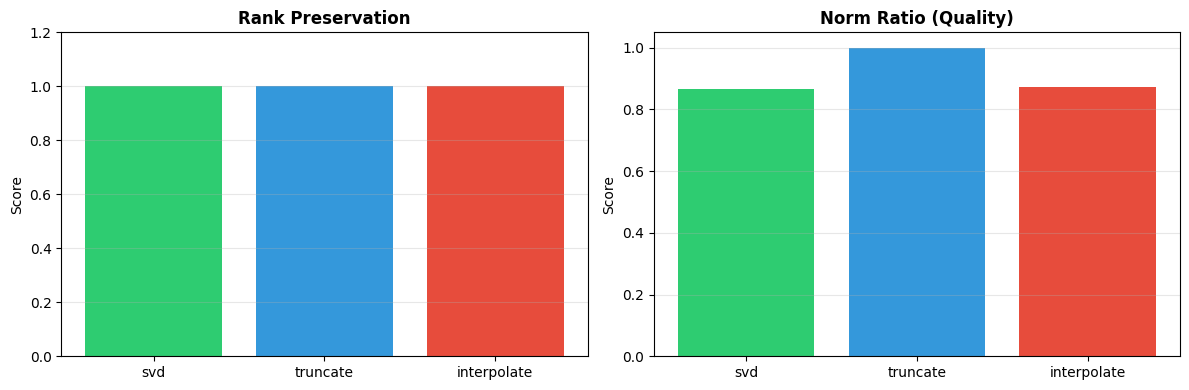


SVD: Best quality preservation
Interpolate: Smooth resizing
Truncate: Fastest, exact values in overlap


In [17]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results).T
df = df[['rank_preservation', 'norm_ratio']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#3498db', '#e74c3c']
ax1.bar(df.index, df['rank_preservation'], color=colors)
ax1.set_title('Rank Preservation', fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1.2)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(df.index, df['norm_ratio'], color=colors)
ax2.set_title('Norm Ratio (Quality)', fontweight='bold')
ax2.set_ylabel('Score')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\nSVD: Best quality preservation')
print('Interpolate: Smooth resizing')
print('Truncate: Fastest, exact values in overlap')

---
## Use Case 4: Production Medical Chatbot

### Comprehensive Medical Dataset

In [18]:
# Brief medical corpus (use medical_production_corpus from training_datasets.py for full version)
medical_corpus = [
    'Type 2 diabetes involves insulin resistance and elevated blood glucose.',
    'Hypertension is a major risk factor for cardiovascular disease.',
    'Asthma causes chronic airway inflammation and breathing difficulties.',
    'Antibiotics treat bacterial infections but not viral infections.',
    'Vaccines stimulate immunity against specific pathogens.',
]

print(f'Medical corpus: {len(medical_corpus)} examples')

Medical corpus: 5 examples


### Train Production Adapter

In [19]:
print('Training medical adapter...\n')

ual.train_adapter(
    adapter_name='medical_pro',
    training_data=medical_corpus,
    rank=16,
    alpha=32,
    epochs=3,
    batch_size=2,
    target_modules=['c_attn', 'c_proj']
)

ual.export_adapter('medical_pro', 'medical_pro.air')
print('\nMedical adapter ready')

2025-10-30 16:23:44.783 | INFO     | ual_adapter.core.adapter:train_adapter:108 - Training adapter 'medical_pro'...
2025-10-30 16:23:44.896 | INFO     | ual_adapter.core.adapter:train_adapter:130 - Training adapter... (simplified implementation)
2025-10-30 16:23:44.905 | INFO     | ual_adapter.core.adapter:train_adapter:161 - ✅ Trained adapter 'medical_pro' with 72 weights
2025-10-30 16:23:44.907 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight -> layer_0.attention_query
2025-10-30 16:23:44.910 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight -> layer_0.attention_query
2025-10-30 16:23:44.911 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight -> layer_0.mlp_down
2025-10-30 16:23:44.914 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.mo

Training medical adapter...



2025-10-30 16:23:44.987 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.8.attn.c_proj.lora_A.default.weight -> layer_8.mlp_down
2025-10-30 16:23:44.988 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.8.attn.c_proj.lora_B.default.weight -> layer_8.mlp_down
2025-10-30 16:23:44.989 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.8.mlp.c_proj.lora_A.default.weight -> layer_8.mlp_down
2025-10-30 16:23:44.989 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.8.mlp.c_proj.lora_B.default.weight -> layer_8.mlp_down
2025-10-30 16:23:44.991 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.9.attn.c_attn.lora_A.default.weight -> layer_9.attention_query
2025-10-30 16:23:44.991 | DEBUG    | ual_adapter.core.air:export_to_air:91 - Mapped base_model.model.transformer.h.9.attn.c_attn.lora_B.defa


Medical adapter ready


### Deploy and Test

In [20]:
target_ual.import_adapter('medical_pro.air')

def medical_bot(question, max_len=80):
    prompt = f'Medical Question: {question}\nAnswer:'
    response = generate(target_model, target_tokenizer, prompt, max_len)
    return response.split('Answer:')[-1].strip()

questions = [
    'What is diabetes?',
    'How does hypertension affect health?',
    'What are antibiotics for?'
]

print('Medical Chatbot Demo\n' + '='*70)
for q in questions:
    print(f'\nQ: {q}')
    print(f'A: {medical_bot(q)}')
    print('-'*70)

print('\nMedical chatbot working!')

2025-10-30 16:23:53.013 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_0.attention_query -> model.layers.0.self_attn.q_proj
2025-10-30 16:23:53.013 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_0.mlp_down -> model.layers.0.mlp.down_proj
2025-10-30 16:23:53.014 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_1.attention_query -> model.layers.1.self_attn.q_proj
2025-10-30 16:23:53.015 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_1.mlp_down -> model.layers.1.mlp.down_proj
2025-10-30 16:23:53.015 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_10.attention_query -> model.layers.10.self_attn.q_proj
2025-10-30 16:23:53.018 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_10.mlp_down -> model.layers.10.mlp.down_proj
2025-10-30 16:23:53.019 | DEBUG    | ual_adapter.core.air:import_from_air:151 - Mapped layer_11.attention_query -> model.layers.11.self_attn.q_proj
20

Medical Chatbot Demo

Q: What is diabetes?
A: Diabetes is a chronic (long-lasting) disease in which the body does not produce or use insulin properly. Insulin is a hormone produced by the pancreas that helps the body to use sugar and fats for energy. Without enough insulin, high levels of sugar and fat
----------------------------------------------------------------------

Q: How does hypertension affect health?
A: Hypertension is a common condition that results from a build-up of blood pressure in the blood vessels. This build-up of blood pressure leads to a condition known as hypertension, which can result in various health problems. Some of the health problems associated with hypertension include heart disease, stroke, high blood
----------------------------------------------------------------------

Q: What are antibiotics for?
A: Antibiotics are medications that can treat bacterial infections. They are used to treat certain types of bacterial infections that are difficult to treat

---
## Summary

### Completed:
- Cross-Architecture Transfer (GPT-2 to TinyLlama)
- Multi-Domain Intelligent Dispatcher
- Projection Methods Comparison
- Production Medical Chatbot

### Key Points:
- **Efficient**: Train 0.01% of parameters
- **Portable**: Train once, deploy anywhere
- **Intelligent**: Automatic domain routing
- **Flexible**: Multiple projection methods

### Resources:
- [Documentation](https://ual-adapter.readthedocs.io)
- [GitHub](https://github.com/hamehrabi/ual-adapter)
- [PyPI](https://pypi.org/project/ual-adapter/)

### Supported Models:
GPT-2, LLaMA, Pythia, Qwen, BERT, T5

### Target Modules Reference:
- **GPT-2**: `['c_attn', 'c_proj']`
- **LLaMA**: `['q_proj', 'v_proj']` or `['q_proj', 'k_proj', 'v_proj', 'o_proj']`
- **BERT**: `['query', 'value']`
- **T5**: `['q', 'v']`

**For comprehensive training data, download `training_datasets.py` from the repository!**

## Cleanup

In [ ]:
import gc
del model, target_model, ual, target_ual
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print('Memory cleared')